In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import nrrd
import json
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
import requests
from anatomy.anatomy_api import AnatomyApi
import scipy.stats as stats
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm
from scipy.optimize import curve_fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.graphics import utils
from statsmodels.formula.api import ols
import scipy

import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

distance_threshold = 800
overlap_threshold = 0.05

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
aapi = AnatomyApi()
ss = aapi.get_summary_structure_data('id')
mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
isocortex = structure_tree.get_structures_by_acronym(['Isocortex'])[0]
cla = structure_tree.get_structures_by_acronym(['CLA'])[0]['id']
HPF = structure_tree.get_structures_by_acronym(['HPF'])[0]
iso = structure_tree.descendant_ids([isocortex['id']])[0]
iso = [structure for structure in iso if structure in ss]
hipp = structure_tree.descendant_ids([HPF['id']])[0]
hipp = [structure for structure in hipp if structure in ss]
ia_map = structure_tree.get_id_acronym_map()
ai_map = {value:key for key, value in ia_map.items()}
ctx_strs = [ai_map[structure] for structure in iso]
hipp_strs = [ai_map[structure] for structure in hipp]
valid_strs = ctx_strs#+hipp_strs #No Cla

In [3]:
import platform
if platform.system() == 'Darwin':
    corrpath = '/Users/jenniferwh/Dropbox/DMN data/correlations/_final'
    path = r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN'
elif platform.system() == 'Windows':
    corrpath = r'C:\Users\jenniferwh\Dropbox\DMN data\correlations\_final'

datpath = os.path.join(path, 'data_files')
savepath = os.path.join(path, '_new_figures', 'Figure_6')
td_dataset = pd.read_csv(os.path.join(path, "target_defined_dataset.csv"))

td_dataset = td_dataset[td_dataset['include'] == 'yes']
td_dataset = td_dataset[td_dataset['source'].isin(valid_strs)]
td_dataset = td_dataset[td_dataset['target_by_polygon'] != 'POST']
print(len(td_dataset))

121


In [4]:
# including primary/secondary switch matches within 500 um, all others no distance or overlap constraint
dat = pd.read_csv(os.path.join(datpath, 'td_matched_correlations.csv'))
print(len(dat))
dat = dat[dat['image_series_id'].isin(td_dataset['image_series_id'].unique())]
dat = dat[dat['match_id'].isin(td_dataset['image_series_id'].unique())]
dat = dat[dat['same_primary'] == True]
dat = dat[dat['same secondary for <60% primary'] != False]
print(len(dat))


1397
973


In [5]:
dat = dat.merge(td_dataset[['image_series_id', 'target_by_polygon', 'CAV_percent_DMN']],
               on = 'image_series_id', how = 'left')
dat.rename(columns = {'CAV_percent_DMN': 'td_CAV_percent_DMN',
                     'target_by_polygon': 'td_target'}, inplace = True)
td_dataset['match_id'] = td_dataset['image_series_id']
dat = dat.merge(td_dataset[['match_id', 'target_by_polygon', 'CAV_percent_DMN']],
               on = 'match_id', how = 'left')
dat.rename(columns = {'CAV_percent_DMN': 'match_CAV_percent_DMN',
                     'target_by_polygon': 'match_target'}, inplace = True)

In [6]:
# check for duplicates
dat['index_original'] = dat.groupby(['image_series_id', 'match_id']).image_series_id.transform('idxmin')    
dat = dat[~dat.duplicated(subset=['image_series_id', 'match_id'], keep='first')]
for isid in dat['image_series_id'].unique():
    matches = dat[dat['image_series_id'] == isid]['match_id'].values
    for match in matches:
        index = dat[(dat['image_series_id'] == match) &
                        (dat['match_id'] == isid)].index
        dat = dat.drop(index)
print(len(dat))

495


In [7]:
# Clearly distance is the most important factor. Apply distance threshold
dat = dat[dat['distance'] < distance_threshold]
print(len(dat))
dat = dat[dat['dice_coefficient'] > overlap_threshold]
print(len(dat))

357
241


In [8]:
print(len(dat))
print(len(dat['match_id'].unique()))

241
76


## Proceed with the best model

#### model fit parameters = [-1.49862876e-01, 8.48657022e-02, -3.46958054e-05,  4.37213721e-02, 8.75721400e-01]
 

In [9]:
def exp(X, a, b, c, d, e):
    x,y,z = X
    return a * 10**(-x / b) + (c * y) + (d * z) + e
popt = [-1.49862876e-01, 8.48657022e-02, -3.46958054e-05, 4.37213721e-02, 8.75721400e-01]

In [10]:
dat['exp_predicted'] = exp((dat['td_injection_size'],
                               dat['distance'].values,
                              dat['dice_coefficient'].values), *popt)

In [11]:
def predband(x, xd, yd, f_vars, conf=0.95):
    """
    Code adapted from Rodrigo Nemmen's post:
    http://astropython.blogspot.com.ar/2011/12/calculating-prediction-band-
    of-linear.html

    Calculates the prediction band of the regression model at the
    desired confidence level.

    Clarification of the difference between confidence and prediction bands:

    "The prediction bands are further from the best-fit line than the
    confidence bands, a lot further if you have many data points. The 95%
    prediction band is the area in which you expect 95% of all data points
    to fall. In contrast, the 95% confidence band is the area that has a
    95% chance of containing the true regression line."
    (from http://www.graphpad.com/guides/prism/6/curve-fitting/index.htm?
    reg_graphing_tips_linear_regressio.htm)

    Arguments:
    - x: array with x values to calculate the confidence band.
    - xd, yd: data arrays.
    - a, b, c: linear fit parameters.
    - conf: desired confidence level, by default 0.95 (2 sigma)

    References:
    1. http://www.JerryDallal.com/LHSP/slr.htm, Introduction to Simple Linear
    Regression, Gerard E. Dallal, Ph.D.
    """
    for ix, val in enumerate(xd):
        if all(x == val):
            index = ix
    alpha = 1. - conf    # Significance
    N = len(xd) * len(xd[index])          # data sample size
    var_n = len(f_vars)  # Number of variables used by the fitted function.

    # Quantile of Student's t distribution for p=(1 - alpha/2)
    q = stats.t.ppf(1. - alpha / 2., N - var_n)

    # Std. deviation of an individual measurement (Bevington, eq. 6.15)
    se = np.sqrt(1. / (N - var_n) * np.sum((yd - exp(xd, *f_vars)) ** 2))

    # Auxiliary definitions
    sx = (x - xd[0].mean()) ** 2
    sxd = np.sum((xd[0] - xd[index].mean()) ** 2)

    # Predicted values (best-fit model)
    yp = exp(xd, *f_vars)
    # Prediction band
    dy = q * se * np.sqrt(1. + (1. / N) + (sx / sxd))

    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy

    return lpb, upb

In [12]:
low_pred_band = pd.DataFrame()
high_pred_band = pd.DataFrame()
for key in ['td_injection_size', 'distance', 'dice_coefficient']:
    low_pred_band[key] = predband(dat[key].values, 
                                       (dat['td_injection_size'].values, 
                                        dat['distance'].values,
                                        dat['dice_coefficient'].values), 
                                       dat['spearman_correlation'].values, popt)[0]
    high_pred_band[key] = predband(dat[key].values, 
                                       (dat['td_injection_size'].values, 
                                        dat['distance'].values,
                                        dat['dice_coefficient'].values), 
                                       dat['spearman_correlation'].values, popt)[1]

In [13]:
dat['low_pred_band'] = low_pred_band.min(axis = 1).values
dat['high_pred_band'] = high_pred_band.max(axis = 1).values

In [14]:
print(len(dat[dat['spearman_correlation'] < dat['exp_predicted']]))
print(len(dat[dat['spearman_correlation'] < dat['low_pred_band']]['image_series_id'].unique()))
print(len(dat))
dat[dat['spearman_correlation'] < dat['low_pred_band']]['source'].unique()

118
14
241


array(['VISp', 'ORBvl', 'ORBl', 'RSPv'], dtype=object)

## Find mean per experiment for target-defined data

In [15]:
all_isids = np.unique(np.concatenate(
    (dat['image_series_id'].unique(), dat['match_id'].unique())))
num_comparisons = []
corr = []
predicted_corr = []
sources = []
inj_sizes = []
mean_ol = []
mean_dist = []
mean_low_pred = []
mean_high_pred = []
frac_low_corr = []
for isid in all_isids:
    if len(dat[dat['image_series_id'] == isid]['td_primary_source'].values) > 0:
        sources.append(dat[dat['image_series_id'] == isid][
            'td_primary_source'].values[0])
        inj_sizes.append(dat[dat['image_series_id'] == isid][
            'td_injection_size'].values[0])
    else:
        sources.append(dat[dat['match_id'] == isid][
            'match_primary_source'].values[0])
        inj_sizes.append(dat[dat['match_id'] == isid][
            'match_injection_size'].values[0])
    dataset = dat[(dat['image_series_id'] == isid) | (
        dat['match_id'] == isid)]
    
    num_comparisons.append(len(dataset))
    frac_low_corr.append(
        len(dataset[dataset['spearman_correlation'] < dataset['low_pred_band']])/len(dataset))
    corr.append(dataset['spearman_correlation'].mean())
    predicted_corr.append(dataset['exp_predicted'].mean())
    mean_ol.append(dataset['dice_coefficient'].mean())
    mean_dist.append(dataset['distance'].mean())
    mean_low_pred.append(dataset['low_pred_band'].min())
    mean_high_pred.append(dataset['high_pred_band'].max())

In [16]:
meandat = pd.DataFrame({'image_series_id': all_isids, 'source': sources, 
                       'injection_size': inj_sizes, 'number_comparisons': num_comparisons, 
                       'fraction_low_corr': frac_low_corr,
                       'spearman_correlation': corr, 'exp_predicted': predicted_corr,
                      'mean_overlap': mean_ol, 'mean_distance': mean_dist, 
                       'low_pred': mean_low_pred})
print(len(meandat))

98


In [17]:
meansig = meandat[meandat['fraction_low_corr'] > 0.5]

In [18]:
len(meansig)

8

In [19]:
meansig['source'].unique()

array(['VISp', 'ORBvl', 'ORBl', 'RSPv'], dtype=object)

In [20]:
meandat.loc[meandat['image_series_id'].isin(meansig['image_series_id'].values), 
            'low_corr_experiment'] = True

In [21]:
dat.loc[(dat['td_CAV_percent_DMN'] > 50) &
        (dat['match_CAV_percent_DMN'] > 50), 'experiment_type'] = 'both in'
dat.loc[(dat['td_CAV_percent_DMN'] < 50) &
        (dat['match_CAV_percent_DMN'] < 50), 'experiment_type'] = 'both out'
dat.loc[(dat['td_CAV_percent_DMN'] < 50) &
        (dat['match_CAV_percent_DMN'] > 50), 'experiment_type'] = 'in-out'
dat.loc[(dat['td_CAV_percent_DMN'] > 50) &
        (dat['match_CAV_percent_DMN'] < 50), 'experiment_type'] = 'in-out'

In [22]:
dat['experiment_type'].unique()

array(['both out', 'in-out', 'both in', nan], dtype=object)

In [23]:
print(len(dat[dat['spearman_correlation'] > dat['high_pred_band']]))
print(len(dat[dat['spearman_correlation'] < dat['low_pred_band']]))

9
28


In [24]:
len(meandat[meandat['fraction_low_corr'] > 0.5])

8

In [25]:
meandat[meandat['fraction_low_corr'] > 0.5]['source'].unique()

array(['VISp', 'ORBvl', 'ORBl', 'RSPv'], dtype=object)

In [26]:
def assign_module(df):
    df.loc[df['source'].isin(['ACAd', 'ACAv', 'ORBl','ORBm', 'ORBvl', 
                                                    'ILA', 'PL', 'FRP']), 'module'] = 'Prefrontal'
    df.loc[df['source'].isin(['VISam', 'RSPagl', 'RSPv', 'VISpm',
                                                    'VISa', 'RSPd']), 'module'] = 'Medial'
    df.loc[df['source'].isin(['SSp-tr', 'SSp-ll', 'SSp-bfd', 'SSp-un',
                                                    'SSp-ul', 'MOs', 'MOp', 'SSs', 'SSp-n',
                                                    'SSp-m']), 'module'] = 'Somatomotor'
    df.loc[df['source'].isin(['VISal', 'VISl', 'VISli', 'VISp', 'VISpl',
                                                    'VISpor', 'VISrl']), 'module'] = 'Visual'
    df.loc[df['source'].isin(['AUDpo', 'AUDd', 'AUDp', 'AUDv']), 
                    'module'] = 'Auditory'
    df.loc[df['source'].isin(['TEa', 'PERI', 'ECT', 'GU', 'AId', 'AIv',
                                                    'AIp', 'VISC']), 'module'] = 'Lateral'
    print(len(df[df['module'].isnull()]))
    return df

In [27]:
dat = assign_module(dat)

0


In [28]:
in_strs = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'VISa', 'VISam', 'RSPagl',
    'RSPd', 'RSPv', 'SSp-tr', 'SSp-ll', 'MOs']
dat.loc[dat['source'].isin(in_strs), 'in-out'] = 'in'
dat.loc[~dat['source'].isin(in_strs), 'in-out'] = 'out'

In [29]:
rspv = dat[(dat['source'] == 'RSPv')]
print(len(rspv))

32


In [30]:
rspv_sig = rspv[rspv['spearman_correlation'] < rspv['low_pred_band']]
print(len(rspv_sig))

10


In [31]:
len(rspv_sig)/len(rspv)

0.3125

## Plot projections from various RSPv injections

In [32]:
all_isids = [592522663, 623838656, 521255975, 561511939, 569904687, 868641659, 112595376]
print(len(all_isids))

7


In [33]:
new_isid = 868641659
online_isids = [isid for isid in all_isids if isid != new_isid]
unionize_path = os.path.join(r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/data_files/alternative_unionizes',
                             'experiment_{0}'.format(str(new_isid)), 
                             'output.json') #new data not online yet
with open(unionize_path, 'r') as jsonfile:
    unionize_dat = json.load(jsonfile)
unionize_dat = pd.DataFrame(unionize_dat)
unionize_dat = unionize_dat[unionize_dat['threshold'] == 0]
unionize_dat.drop_duplicates(inplace = True)
unionize_dat.rename(columns = {'projection_volume_above_threshold': 'projection_volume',
                           'normalized_projection_volume_above_threshold': 
                               'normalized_projection_volume',
                               'image_series_id': 'experiment_id'}, 
    inplace = True)
td_unionize = unionize_dat[(unionize_dat['is_injection'] == False) &
                           (unionize_dat['hemisphere_id'].isin([1,2]))]
td_unionize = td_unionize[['experiment_id', 'hemisphere_id', 'is_injection',
                          'normalized_projection_volume', 'structure_id']]

In [34]:
unionize_dat = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = online_isids,
                                                is_injection = False,
                                                hemisphere_ids = [1,2],
                                                structure_ids = ss))
unionize_dat.loc[(unionize_dat['experiment_id'] == 112595376) &
                (unionize_dat['hemisphere_id'] == 1), 'hemisphere_id'] = 0
unionize_dat.loc[(unionize_dat['experiment_id'] == 112595376) &
                (unionize_dat['hemisphere_id'] == 2), 'hemisphere_id'] = 1
unionize_dat.loc[(unionize_dat['experiment_id'] == 112595376) &
                (unionize_dat['hemisphere_id'] == 0), 'hemisphere_id'] = 2
unionize_dat = unionize_dat[['experiment_id', 'hemisphere_id', 'is_injection',
                           'normalized_projection_volume', 'structure_id']]
unionize_dat = pd.concat([unionize_dat, td_unionize])
print(len(unionize_dat['experiment_id'].unique()))

7


In [35]:
rspv_targets = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 
                'VISa', 'VISam', 'RSPagl', 'RSPd', 'RSPv', 'VISpm', 'VISal', 'VISl', 
                'VISp', 'VISpl', 'VISli', 'VISpor', 'VISrl']
structures = [ia_map[structure] for structure in rspv_targets]
pltdat = unionize_dat[(unionize_dat['hemisphere_id'] == 1) &
                      (unionize_dat['structure_id'].isin(structures))]

In [36]:
pltdat.loc[pltdat['experiment_id'] == 112595376, 'expt_type'] = 'WT'
pltdat.loc[pltdat['experiment_id'].isin([569904687, 868641659]), 'expt_type'] = 'VISp/VISl'
pltdat.loc[pltdat['experiment_id'].isin([592522663, 623838656]), 'expt_type'] = 'PL'
pltdat.loc[pltdat['experiment_id'].isin([521255975, 561511939]), 'expt_type'] = 'ACAd'

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[it

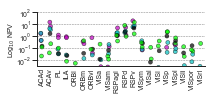

In [37]:
fig, ax = plt.subplots(figsize = (3, 1))
sns.stripplot('structure_id', 'normalized_projection_volume', 
              data = pltdat, order = structures, hue = 'expt_type', 
              hue_order = ['PL', 'ACAd', 'VISp/VISl', 'WT'],
            palette = ['m', 'c', 'lime', 'k'], dodge = False, s=4, linewidth = 0.5,
              alpha = 0.7)
ax.set_xticklabels(rspv_targets, rotation=90, fontsize = 7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 7)
ax.set_ylim([10**-2.5, 100])
ax.set_yscale('log')
sns.despine()
ax.set_ylabel('Log$_{10}$ NPV', fontsize = 7)
ax.set_xlabel(None)
ax.tick_params(left = True, pad = 1)
ax.tick_params('x', pad = -3)
ax.yaxis.labelpad = -1
ax.legend_.remove()
ax.set_yticks([10**-2, 10**-1, 10**0, 10**1, 10**2])
ax.axhline(y = 0.01, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.axhline(y = 0.1, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.axhline(y = 1, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.axhline(y = 10, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.axhline(y = 100, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
plt.savefig(os.path.join(savepath, 'RSPv_targets_NPV_ipsi.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [45]:
pltdat_mean['expt_type'].unique()

array(['ACAd', 'PL', 'VISp/VISl', 'WT'], dtype=object)

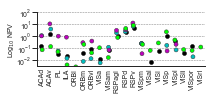

In [49]:
fig, ax = plt.subplots(figsize = (3, 1))
pltdat_mean = pltdat.groupby(['expt_type', 'structure_id']).mean().reset_index()
sns.stripplot('structure_id', 'normalized_projection_volume', 
              data = pltdat_mean[pltdat_mean['expt_type'] == 'WT'], 
              order = structures, color = 'k', 
              dodge = False, s=4, linewidth = 0.5, zorder = -1)
sns.stripplot('structure_id', 'normalized_projection_volume', 
              data = pltdat_mean[pltdat_mean['expt_type'] != 'WT'], 
              order = structures, hue = 'expt_type', 
              hue_order = ['PL', 'ACAd', 'VISp/VISl'],
            palette = ['m', 'c', 'lime'], dodge = False, s=4, linewidth = 0.5)
ax.set_xticklabels(rspv_targets, rotation=90, fontsize = 7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 7)
ax.set_ylim([10**-2.5, 100])
ax.set_yscale('log')
sns.despine()
ax.set_ylabel('Log$_{10}$ NPV', fontsize = 7)
ax.set_xlabel(None)
ax.tick_params(left = True, pad = 1)
ax.tick_params('x', pad = -3)
ax.yaxis.labelpad = -1
ax.legend_.remove()
ax.set_yticks([10**-2, 10**-1, 10**0, 10**1, 10**2])
ax.axhline(y = 0.01, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -2)
ax.axhline(y = 0.1, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -2)
ax.axhline(y = 1, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -2)
ax.axhline(y = 10, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -2)
ax.axhline(y = 100, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -2)
plt.savefig(os.path.join(savepath, 'RSPv_targets_NPV_ipsi_mean.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [38]:
prefrontal = ['ACAd', 'ACAv', 'ORBl','ORBm', 'ORBvl', 'ILA', 'PL', 'FRP']
medial = ['VISam', 'RSPagl', 'RSPv', 'VISpm','VISa', 'RSPd']
visual = ['VISal', 'VISl', 'VISli', 'VISp', 'VISpl', 'VISpor', 'VISrl']
prefrontal_strs = [ia_map[structure] for structure in prefrontal]
medial_strs = [ia_map[structure] for structure in medial]
visual_strs = [ia_map[structure] for structure in visual]
pltdat = unionize_dat[(unionize_dat['hemisphere_id'] == 1) &
                      (unionize_dat['structure_id'].isin(
                          prefrontal_strs+medial_strs+visual_strs))]
pltdat.loc[np.log10(pltdat['normalized_projection_volume']+10e-5) < -2.5,
          'normalized_projection_volume'] = 10**-2.5

In [39]:
pltdat.loc[pltdat['structure_id'].isin(prefrontal_strs), 'module'] = 'Prefrontal'
pltdat.loc[pltdat['structure_id'].isin(medial_strs), 'module'] = 'Medial'
pltdat.loc[pltdat['structure_id'].isin(visual_strs), 'module'] = 'Visual'

In [40]:
pltdat.loc[pltdat['experiment_id'] == 112595376, 'expt_type'] = 'WT'
pltdat.loc[pltdat['experiment_id'].isin([569904687, 868641659]), 'expt_type'] = 'VISp/VISl'
pltdat.loc[pltdat['experiment_id'].isin([592522663, 623838656]), 'expt_type'] = 'PL'
pltdat.loc[pltdat['experiment_id'].isin([521255975, 561511939]), 'expt_type'] = 'ACAd'

In [41]:
pltdat.head()

,experiment_id,hemisphere_id,is_injection,normalized_projection_volume,structure_id,module,expt_type
6,592522663,1,False,0.136247,394,Medial,PL
53,592522663,1,False,0.003162,409,Visual,PL
78,592522663,1,False,0.014635,184,Prefrontal,PL
87,592522663,1,False,0.003162,723,Prefrontal,PL
102,592522663,1,False,0.003162,312782546,Medial,PL


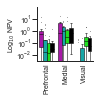

In [42]:
fig, ax = plt.subplots(figsize = (1, 1))
sns.boxplot('module', 'normalized_projection_volume', 
              data = pltdat, hue = 'expt_type', hue_order = ['PL', 'ACAd', 'VISp/VISl', 'WT'],
            palette = ['m', 'c', 'lime', 'k'],
             order = ['Prefrontal', 'Medial', 'Visual'], linewidth = 0.5,
            fliersize = 0.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = 7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 7)
ax.set_yscale('log')
ax.set_ylim([10**-2.5, 100])
ax.set_yticks([10**-2, 10**-1, 10**0, 10**1])
sns.despine()
ax.set_ylabel('Log$_{10}$ NPV', fontsize = 7)
ax.set_xlabel(None)
ax.tick_params(left = True, pad = 1)
ax.tick_params('x', pad = -3)
ax.yaxis.labelpad = -1
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'RSPv_targets_NPV_ipsi_modules_combined.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

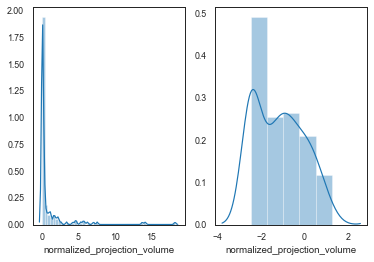

In [43]:
fig, ax = plt.subplots(1, 2)
sns.distplot(pltdat['normalized_projection_volume'], ax = ax[0])
sns.distplot(np.log10(pltdat['normalized_projection_volume']+10e-5), ax = ax[1])

In [44]:
#drop wt for stats
print(len(pltdat))
pltdat = pltdat[pltdat['expt_type'] != 'WT']
print(len(pltdat))

147
126


In [45]:
pltdat['log_NPV'] = np.log10(pltdat['normalized_projection_volume']+10e-5)
formula = 'log_NPV~C(module)*C(expt_type)' 
model = ols(formula, pltdat).fit()
aov_table = anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(module),23.7679,2.0,11.7586,0.0000
C(expt_type),1.7289,2.0,0.8553,0.4278
C(module):C(expt_type),23.3292,4.0,5.7708,0.0003
Residual,118.2477,117.0,NaN,NaN


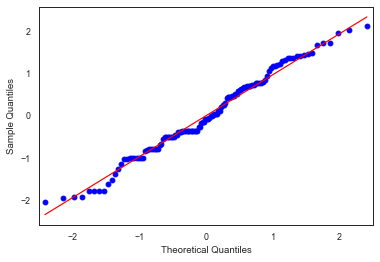

In [46]:
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [47]:
for module in ['Prefrontal', 'Medial', 'Visual']:
    print(module)
    mc = MultiComparison(pltdat[(pltdat['module'] == module)]['log_NPV'], 
                         pltdat[(pltdat['module'] == module)]['expt_type'])
    mc_results = mc.tukeyhsd()
    print(mc_results)

Prefrontal
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj   lower   upper  reject
-------------------------------------------------------
 ACAd      PL     0.9209  0.0354  0.053   1.7888  True 
 ACAd  VISp/VISl -0.2072  0.8159 -1.0751  0.6608 False 
  PL   VISp/VISl -1.1281  0.008   -1.996 -0.2602  True 
-------------------------------------------------------
Medial
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj   lower  upper  reject
------------------------------------------------------
 ACAd      PL    -0.2599  0.8548 -1.5006 0.9807 False 
 ACAd  VISp/VISl -0.0918   0.9   -1.3325 1.1488 False 
  PL   VISp/VISl  0.1681   0.9   -1.0726 1.4088 False 
------------------------------------------------------
Visual
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj   lower  upper  reject
------------------------------------------------------
 ACAd      PL    -0.1418  0.8584 

## Text

In [48]:
rspv[(rspv['source'] == 'RSPv') &
    (rspv['td_target'] == 'PL') &
   (rspv['match_target'] == 'PL')][['image_series_id',
                                    'match_id',
                                    'spearman_correlation',
                                    'distance',
                                    'dice_coefficient',
                                    'experiment_type']]

,image_series_id,match_id,spearman_correlation,distance,dice_coefficient,experiment_type
134,592522663,623838656,0.618487,199.364193,0.35941,both in


In [49]:
rspv[(rspv['source'] == 'RSPv') &
    (rspv['td_target'] == 'ACAd') &
   (rspv['match_target'] == 'ACAd')][['image_series_id',
                                                                    'match_id',
                                                                    'spearman_correlation',
                                                                    'distance',
                                                                    'dice_coefficient',
                                                                    'experiment_type']]

,image_series_id,match_id,spearman_correlation,distance,dice_coefficient,experiment_type
113,555012592,570071403,0.741734,177.750710,0.621497,both in
114,555012592,571647261,0.731916,65.688797,0.973482,both in
388,561511939,521255975,0.837052,433.073188,0.134674,both in
469,571647261,570071403,0.784812,115.150350,0.844992,both in


In [50]:
td_dataset[(td_dataset['source'] == 'RSPv') & 
           (td_dataset['target_by_polygon'].isin(['ACAd', 'ACAv', 'MOs']))]

,image_series_id,specimen_name,sex,age_at_injection,injection_structures,injection_volume,primary_injection_structure,source,structure_id,target_by_polygon,...,experiment_detail_page,injection dmn fraction,projection dmn fraction,distance coefficient,DMN coefficient,CAV_percent_DMN,WT_matches,TD_matches,injection_matched_group,match_id
3,475828414,Ai75(T503)-176840,M,53.0,[886],0.006795,886.0,RSPv,886.0,MOs,...,http://connectivity.brain-map.org/projection/e...,1.000000,0.915411,-0.002608,0.001505,99.659112,"[100148142, 100140949, 159832064]","[475830603, 561512675, 616674416]",[nan],475828414
5,475830603,Ai75(RCL-nT)-181901,M,55.0,"[879, 886]",0.034618,879.0,RSPv,886.0,ACAv,...,http://connectivity.brain-map.org/projection/e...,0.999745,0.914113,-0.003413,0.009542,97.215782,"[100148142, 100140949, 159832064, 591535205]","[475828414, 616674416]",[nan],475830603
29,521255975,Ai75(T503)-215057,M,55.0,"[886, 1037]",0.005848,886.0,RSPv,886.0,ACAd,...,http://connectivity.brain-map.org/projection/e...,0.053660,0.600392,-0.001616,0.004499,100.000000,[112595376],"[561511939, 569904687, 592522663, 592724077, 6...","[112595376, 521255975, 592522663, 623838656, 6...",521255975
55,555012592,Ai75(T503)-271670,M,58.0,"[879, 886]",0.011666,879.0,RSPv,886.0,ACAd,...,http://connectivity.brain-map.org/projection/e...,1.000000,0.875807,-0.002836,0.011745,100.000000,"[501484658, 592540591, 166054929]","[570071403, 571647261]",[nan],555012592
61,561511939,Ai75(T601)-276538,M,54.0,[886],0.005104,886.0,RSPv,886.0,ACAd,...,http://connectivity.brain-map.org/projection/e...,0.399288,0.708294,-0.002409,0.006872,100.000000,"[501484658, 112595376]","[521255975, 592522663]",[nan],561511939
73,570071403,Ai75(T503)-291431,M,56.0,"[879, 886]",0.002877,879.0,RSPv,886.0,ACAd,...,http://connectivity.brain-map.org/projection/e...,1.000000,0.872069,-0.000964,0.003847,100.000000,"[501484658, 592540591, 166054929]","[555012592, 571647261]",[nan],570071403
77,571647261,Ai75(T503)-281795,F,55.0,"[879, 886]",0.024159,879.0,RSPv,886.0,ACAd,...,http://connectivity.brain-map.org/projection/e...,1.000000,0.835767,-0.003579,0.009697,89.968845,"[592540591, 166054929, 501484658]","[555012592, 570071403]",[nan],571647261


In [51]:
alldat = pd.read_csv(os.path.join(datpath, 'good_td_wt_correlations.csv'))
print(len(alldat))

586


In [52]:
alldat[alldat['image_series_id'].isin([592522663, 623838656])]

,distance,exclusion_zone_overlap,fraction of match covered by td exclusion zone,fraction of match covered by td injection,image_series_id,injection_overlap,match_id,pearson_correlation,source,spearman_correlation,...,Julie call,PN_type_JH,JW_pass-fail,dice,include,CAV_percent_DMN,exp_predicted,low_pred_band,high_pred_band,sig
146,309.266574,0.191553,0.336906,0.031516,592522663,0.421307,112595376,0.908320,RSPv,0.527093,...,Y,IT PT CT,good,0.062609,yes,97.940510,0.719958,0.614106,0.825810,True
191,375.094674,0.205033,0.308338,0.066791,623838656,0.645127,112595376,0.824779,RSPv,0.700694,...,Y,IT PT CT,good,0.129753,yes,95.186863,0.728922,0.623028,0.834815,False


In [53]:
alldat[alldat['image_series_id'].isin([521255975, 561511939])][['image_series_id',
                                                                    'match_id',
                                                                'source',
                                                                    'spearman_correlation',
                                                                    'distance']]

,image_series_id,match_id,source,spearman_correlation,distance
32,561511939,501484658,RSPv,0.826827,606.813030
171,561511939,112595376,RSPv,0.774766,677.760122
188,521255975,112595376,RSPv,0.815790,297.706103


In [54]:
#rostral
alldat[alldat['image_series_id'].isin([475828414, 475830603])]['spearman_correlation'].std()

0.024631843768503213

In [55]:
#dorsal
alldat[alldat['image_series_id'].isin([555012592, 570071403,
                                      571647261])]['spearman_correlation'].std()

0.06355306331247931

In [56]:
td_glm_dat = pd.read_csv(os.path.join(datpath,
                            'td_ctx_injections_DMN_and_core_projections_coefficients.csv'))
td_glm_dat.rename(columns = {'image_series_id': 'id'}, inplace = True)
ctx_coord_dat = pd.read_csv(os.path.join(datpath,
                            'cortical_flatmap_coordinates.csv'))
td = td_glm_dat[td_glm_dat['id'].isin(td_dataset['image_series_id'].unique())]
td = td.merge(ctx_coord_dat[['id', 'top_x', 'top_y']], 
                              on = 'id', how = 'left')
print(len(td))
td.rename(columns = {'id': 'image_series_id'}, inplace = True)

121


In [57]:
td = td.merge(td_dataset[['image_series_id', 
                          'target_by_polygon',
                          'CAV_percent_DMN']], how = 'left')

In [58]:
td.loc[td['image_series_id'].isin([569904687, 868641659]), 'target_by_polygon'] = 'VISp/VISl'

In [59]:
td[td['image_series_id'].isin(
    rspvc['image_series_id'].unique())][['image_series_id',
                                         'injection structure', 
                                         'target_by_polygon']]

NameError: name 'rspvc' is not defined

In [ ]:
rspvc = td[td['image_series_id'].isin(all_isids)]
print(len(rspvc))

In [ ]:
wt = pd.read_csv(os.path.join(datpath,
                        'wt_cre_ctx_injections_DMN_and_core_projections_coefficients.csv'))
wt.rename(columns = {'id': 'image_series_id'})
wt = wt.merge(ctx_coord_dat[['id', 'top_x', 'top_y']], 
                              on = 'id', how = 'left')
print(len(wt))
wt.rename(columns = {'id': 'image_series_id'}, inplace = True)
wt['target_by_polygon'] = 'WT'
wt['CAV_percent_DMN'] = np.nan

In [ ]:
rspvc = pd.concat([rspvc, wt[wt['image_series_id'].isin(all_isids)]])

In [ ]:
rspvc[['injection structure', 'target_by_polygon', 
      'injection dmn fraction', 'projection dmn fraction']]

In [ ]:
plot_order = ['PL', 'ACAd', 'VISp/VISl', 'WT']
fig, ax = plt.subplots(figsize = (0.5, 1))
sns.stripplot('target_by_polygon', 'projection dmn fraction', data = rspvc,
             ax = ax, order = plot_order, hue = 'target_by_polygon',
             palette = ['m', 'c', 'lime', 'k'], hue_order = plot_order)
plt.xticks(fontsize = 8, rotation=90)
ax.set_ylim([0,1])
sns.despine()
ax.tick_params(left = True)
ax.tick_params(axis = 'x', pad = -3)
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel('Target', fontsize = 8)
ax.set_ylabel('Projection DMN Fraction', fontsize = 8)
plt.axhline(y=0.5, color = 'gray', linestyle = '--', linewidth = 0.5)
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'RSPv_projection_dmn_fraction.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [ ]:
rspvc[rspvc['target_by_polygon'].isin(['PL', 'ACAd'])]['projection dmn fraction'].std()

In [ ]:
rspvc['target_by_polygon'].unique()

In [ ]:
rspvc[rspvc['target_by_polygon'] == 'VISp/VISl']['projection dmn fraction']

In [ ]:
major_divisions = structure_tree.get_structures_by_set_id([687527670])

In [ ]:
md_ids = [structure['id'] for structure in major_divisions]

In [ ]:
new_isid = 868641659
online_isids = [isid for isid in all_isids if isid != new_isid]
unionize_path = os.path.join(r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/data_files/alternative_unionizes',
                             'experiment_{0}'.format(str(new_isid)), 
                             'output.json') #new data not online yet
with open(unionize_path, 'r') as jsonfile:
    unionize_dat = json.load(jsonfile)
unionize_dat = pd.DataFrame(unionize_dat)
unionize_dat = unionize_dat[unionize_dat['threshold'] == 0]
unionize_dat.drop_duplicates(inplace = True)
unionize_dat.rename(columns = {'projection_volume_above_threshold': 'projection_volume',
                           'normalized_projection_volume_above_threshold': 
                               'normalized_projection_volume',
                               'image_series_id': 'experiment_id'}, 
    inplace = True)
td_unionize = unionize_dat[(unionize_dat['is_injection'] == False) &
                           (unionize_dat['hemisphere_id'] == 3)]
td_unionize = td_unionize[['experiment_id', 'hemisphere_id', 'is_injection',
                          'normalized_projection_volume', 'structure_id']]

unionize_dat = pd.DataFrame( mcc.get_structure_unionizes(experiment_ids = online_isids,
                                                is_injection = False,
                                                hemisphere_ids = [3],
                                                structure_ids = md_ids))
unionize_dat = unionize_dat[['experiment_id', 'hemisphere_id', 'is_injection',
                           'normalized_projection_volume', 'structure_id']]
unionize_dat = pd.concat([unionize_dat, td_unionize])

In [ ]:
pltdat = unionize_dat[(unionize_dat['structure_id'].isin(md_ids))]
pltdat.loc[np.log10(pltdat['normalized_projection_volume']) < -1.5,
                          'normalized_projection_volume'] = 10**-1.5

In [ ]:
major_div_labels = [ai_map[structure] for structure in md_ids]
print(major_div_labels)

In [ ]:
fig, ax = plt.subplots(figsize = (3, 1.5))
sns.pointplot('structure_id', 'normalized_projection_volume', 
              data = pltdat[pltdat['experiment_id'] == 112595376], #wt
             order = md_ids, color = 'k', scale = 0.5)
for isid in [569904687, 868641659]: #VISl and VISp
    sns.pointplot('structure_id', 'normalized_projection_volume', 
              data = pltdat[pltdat['experiment_id'] == isid],
             order = md_ids, color = 'lime', scale = 0.5)
for isid in [592522663, 623838656]: #PL
    sns.pointplot('structure_id', 'normalized_projection_volume', 
              data = pltdat[pltdat['experiment_id'] == isid],
             order = md_ids, color = 'm', scale = 0.5)
for isid in [521255975, 561511939]: #ACAd
    sns.pointplot('structure_id', 'normalized_projection_volume', 
              data = pltdat[pltdat['experiment_id'] == isid],
             order = md_ids, color = 'c', scale = 0.5)
ax.set_xticklabels(major_div_labels, rotation=90, fontsize = 8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 8)
ax.set_ylim([10**-1.5, 50])
ax.set_yscale('log')
sns.despine()
ax.set_ylabel('Log$_{10}$ NPV', fontsize = 8)
ax.set_xlabel('Ipsilateral Target', fontsize = 8)
ax.tick_params(left = True, pad = 1)
ax.tick_params('x', pad = -3)
ax.yaxis.labelpad = -1
ax.axhline(y = 10**-1.5, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
plt.savefig(os.path.join(savepath, 'RSPv_targets_major_divs_ipsi.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [ ]:
selected_md_labels = ['Isocortex', 'TH']
selected_md_ids = [ia_map[structure] for structure in selected_md_labels]
fig, ax = plt.subplots(figsize = (0.5, 1.5))
sns.stripplot('structure_id', 'normalized_projection_volume', 
              data = pltdat[pltdat['experiment_id'] == 112595376], #wt
             order = selected_md_ids, color = 'k')
for isid in [569904687, 868641659]: #VISl and VISp
    sns.stripplot('structure_id', 'normalized_projection_volume', 
              data = pltdat[pltdat['experiment_id'] == isid],
             order = selected_md_ids, color = 'lime', alpha = 0.7, dodge = True)
for isid in [592522663, 623838656]: #PL
    sns.stripplot('structure_id', 'normalized_projection_volume', 
              data = pltdat[pltdat['experiment_id'] == isid],
             order = selected_md_ids, color = 'm', alpha = 0.7)
for isid in [521255975, 561511939]: #ACAd
    sns.stripplot('structure_id', 'normalized_projection_volume', 
              data = pltdat[pltdat['experiment_id'] == isid],
             order = selected_md_ids, color = 'c', alpha = 0.7)
ax.set_xticklabels(selected_md_labels, rotation=90, fontsize = 8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 8)
ax.set_ylim([10**-1.5, 100])
ax.set_yscale('log')
sns.despine()
ax.set_ylabel('Log$_{10}$ NPV', fontsize = 8)
ax.set_xlabel('', fontsize = 8)
ax.set_yticks([10**0, 10**1, 10**2])
ax.tick_params(left = True, pad = 1)
ax.tick_params('x', pad = -3)
ax.yaxis.labelpad = -1
ax.set_yticks([10**0, 10**1, 10**2])
ax.axhline(y = 1, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.axhline(y = 10, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
ax.axhline(y = 100, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5, zorder = -1)
plt.savefig(os.path.join(savepath, 'RSPv_targets_selected_major_divs_ipsi.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)